# What is affecting the logerror?

**Quick Notebook Reference**

1. Project Plan
2. Imports
3. Acquire
4. Prep
5. Exploration 
6. Models
7. Model Evaluation
8. Final Conclusions

# Project Plan

**Acquisition, Prep, and Initial Exploration**

- Correct Data types (ie. turn zip code into string)
- Handle Missing Values
- Handle Outliers
- Remove/repair erroneous data


**Exploration with Clustering**

By reducing the noise of the continuous variable, we can possibly see trends easier by turning this continuous variable into clusters and then comparing those clusters with respect to other variables through visualizations or tests

Perform clustering with logerror as the only feature used in the clustering algorithm. Decide on a number of clusters to use, and store the cluster predictions back onto your data frame as cluster_target. Look at the centroids that were produced in this process. What do they tell you?

Use the produced clusters to help you explore through visualization how logerror relates to other variables. (A common way to do this is to use color to indicate the cluster id, and the other variables can be your x-axis and y-axis.

1. Cluster Independent Variables
2. Test the Significance of Clusters


**Modeling**
- Feature Engineering
- Train at least 3 different models
- Evaluate best model on test data


Goal: Improve our original estimate of the log error by using clustering methodologies.

# Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

#exploration
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats

#modeling
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#py files
import acquire
import prepare
import preprocessing
import explore
import model

# Set DataFrame to show all columns
pd.set_option('display.max_columns', 200)

# Acquire

* We brought in data from the MySQL zillow database
    * We brought in every piece of information possible with a few constraints:
        * Only 2017 properties
        * Only the most recent transaction date
        * Must have latitude and longitude info
        * Must be a Single Family Residence
* We also removed any column that was over 80% null or that were id columns
* The final DataFrame is saved locally to a .csv

In [2]:
acquire.get_data()

,id,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,airconditioningdesc,heatingorsystemdesc,propertylandusedesc
0,1727539,14297519,3.5,4.0,NaN,3.5,3100.0,3100.0,6059.0,3.0,2.0,33634931.0,-117869207.0,4506.0,NaN,122,261.0,NaN,6.059063e+07,53571.0,1286.0,96978.0,0.0,NaN,1998.0,485713.0,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,0.025595,2017-01-01,NaN,NaN,Single Family Residential
1,1387261,17052889,1.0,2.0,NaN,1.0,1465.0,1465.0,6111.0,1.0,1.0,34449266.0,-119281531.0,12647.0,NaN,1110,261.0,NaN,6.111001e+07,13091.0,2061.0,97099.0,5.0,NaN,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13,0.055619,2017-01-01,NaN,NaN,Single Family Residential
2,11677,14186244,2.0,3.0,NaN,2.0,1243.0,1243.0,6059.0,2.0,2.0,33886168.0,-117823170.0,8432.0,1.0,122,261.0,NaN,6.059022e+07,21412.0,1286.0,97078.0,6.0,NaN,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13,0.005383,2017-01-01,NaN,NaN,Single Family Residential
3,2288172,12177905,3.0,4.0,8.0,3.0,2376.0,2376.0,6037.0,3.0,NaN,34245180.0,-118240722.0,13038.0,1.0,0101,261.0,LCR110000*,6.037300e+07,396551.0,3101.0,96330.0,0.0,1.0,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,-0.103410,2017-01-01,NaN,Central,Single Family Residential
4,781532,12095076,3.0,4.0,9.0,3.0,2962.0,2962.0,6037.0,3.0,NaN,34145202.0,-118179824.0,63000.0,1.0,0101,261.0,PSR2,6.037461e+07,47019.0,3101.0,96293.0,0.0,1.0,1950.0,276684.0,773303.0,2016.0,496619.0,9516.26,6.037461e+13,-0.001011,2017-01-01,Central,Central,Single Family Residential
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52315,673515,11000655,2.0,2.0,6.0,2.0,1286.0,1286.0,6037.0,2.0,NaN,34245368.0,-118282383.0,47405.0,NaN,0100,261.0,LARE40,6.037101e+07,12447.0,3101.0,96284.0,0.0,1.0,1940.0,70917.0,354621.0,2016.0,283704.0,4478.43,6.037101e+13,0.020615,2017-09-20,NaN,Central,Single Family Residential
52316,2968375,17239384,2.0,4.0,NaN,2.0,1612.0,1612.0,6111.0,2.0,2.0,34300140.0,-118706327.0,12105.0,NaN,1111,261.0,NaN,6.111008e+07,27110.0,2061.0,97116.0,7.0,NaN,1964.0,50683.0,67205.0,2016.0,16522.0,1107.48,6.111008e+13,0.013209,2017-09-21,NaN,NaN,Single Family Residential
52317,1843709,12773139,1.0,3.0,4.0,1.0,1032.0,1032.0,6037.0,1.0,NaN,34040895.0,-118038169.0,5074.0,NaN,0100,261.0,SER1*,6.037434e+07,36502.0,3101.0,96480.0,0.0,1.0,1954.0,32797.0,49546.0,2016.0,16749.0,876.43,6.037434e+13,0.037129,2017-09-21,Central,Central,Single Family Residential
52318,1187175,12826780,2.0,3.0,6.0,2.0,1762.0,1762.0,6037.0,2.0,NaN,33937685.0,-117996709.0,6347.0,NaN,0100,261.0,WHR16000*,6.037503e+07,14634.0,3101.0,96171.0,0.0,1.0,1955.0,140000.0,522000.0,2016.0,382000.0,6317.15,6.037503e+13,0.007204,2017-09-25,NaN,Central,Single Family Residential


# Prepare

* We then remove more columns due to them having to many nulls to impute or having information that was not necessary to explore at this time.
* We then imputed multiple columns using the median of that columns
    * `calculatedfinishedsquarefeet`
    * `finishedsquarefeet12`
    * `lotsizesquarefeet`
    * `yearbuilt`
    * `structuretaxvaluedollarcnt`
    * `taxvaluedollarcnt`
    * `landtaxvaluedollarcnt`
    * `taxamount`
* We then transformed some to the columns to provide data differently
    * `fips` with its integer identifier of a county was replaced with the `County` column that contained the string name of the county
    * `garagecnt` and `poolcnt` were combined into the `extras` column that contained one of four values:
    * `Garage and Pool`
    * `Garage Only`
    * `Pool Only`
    * `No Pool or Garage`
* We then removed rows that had 0 bedrooms or 0 bathrooms
* We then handled the outliers in each columns except for `logerror`
    * Each columns was analyzed with IQR and a k of 3
    * There were now lower outliers so only upper outliers were removed

In [3]:
zillow = prepare.wrangle_data()

In [4]:
zillow

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,finishedsquarefeet12,latitude,longitude,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,transactiondate,extras,County
0,3.5,4.0,3100.0,3100.0,33634931.0,-117869207.0,4506.0,1998.0,485713.0,1023282.0,537569.0,11013.72,0.025595,2017-01-01,Garage Only,Orange
1,1.0,2.0,1465.0,1465.0,34449266.0,-119281531.0,12647.0,1967.0,88000.0,464000.0,376000.0,5672.48,0.055619,2017-01-01,Garage Only,Ventura
2,2.0,3.0,1243.0,1243.0,33886168.0,-117823170.0,8432.0,1962.0,85289.0,564778.0,479489.0,6488.30,0.005383,2017-01-01,Garage and Pool,Orange
3,3.0,4.0,2376.0,2376.0,34245180.0,-118240722.0,13038.0,1970.0,108918.0,145143.0,36225.0,1777.51,-0.103410,2017-01-01,Pool Only,Los Angeles
5,1.0,2.0,738.0,738.0,34149214.0,-118239357.0,4214.0,1922.0,18890.0,218552.0,199662.0,2366.08,0.101723,2017-01-01,No Pool or Garage,Los Angeles
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52314,2.0,4.0,1633.0,1633.0,33870815.0,-118070858.0,4630.0,1962.0,125466.0,346534.0,221068.0,4175.08,0.001082,2017-09-19,No Pool or Garage,Los Angeles
52316,2.0,4.0,1612.0,1612.0,34300140.0,-118706327.0,12105.0,1964.0,50683.0,67205.0,16522.0,1107.48,0.013209,2017-09-21,Garage Only,Ventura
52317,1.0,3.0,1032.0,1032.0,34040895.0,-118038169.0,5074.0,1954.0,32797.0,49546.0,16749.0,876.43,0.037129,2017-09-21,No Pool or Garage,Los Angeles
52318,2.0,3.0,1762.0,1762.0,33937685.0,-117996709.0,6347.0,1955.0,140000.0,522000.0,382000.0,6317.15,0.007204,2017-09-25,No Pool or Garage,Los Angeles


# Exploration
- Before beginning exploration we created 4 new variables:
    1. Tax rate = train.taxamount/train.taxvaluedollarcnt
    2. Acres columns = df.lotsizesquarefeet/43560
    3. Dollar/sqft - liveable = df.structuretaxvaluedollarcnt/df.calculatedfinishedsquaref
    4. Dollar/sqft - land = df.landtaxvaluedollarcnt/df.lotsizesquarefeet
    
    
- In this section we will
    1. Look at a County overview
    2. Cluster the Target Variable (logerror)
    3. Plot the logerror cluster against various features
    4. Explore correlations
    5. Cluster Variables
    6. Stats testing
    
    

In [5]:
#bring in the new features
zillow = preprocessing.new_features(zillow)

#split the data into test and train
train, test = preprocessing.split_data(zillow, .7, 123)

#scale the numeric data
scaler, train_scaled, test_scaled = preprocessing.scale_columns(train, test)

## County Overview
Let's take a quick look at the county overviews and get an idea of distributions

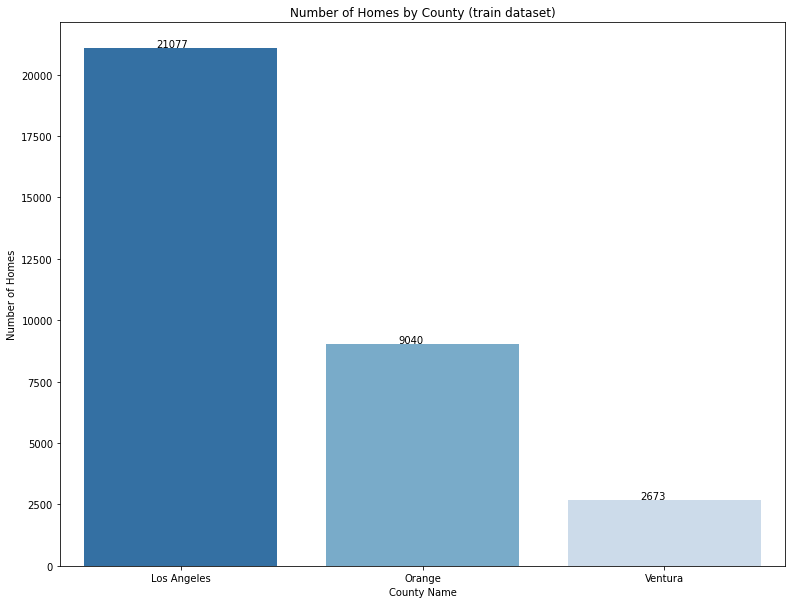

In [6]:
#function to bring in visual of home counts by county
explore.num_home_by_county(train)

**Takeawys:**
- Roughly 64% of the homes are in LA County
- Roughly 28% are in Orange County
- Leaving Ventura County with only 8% 

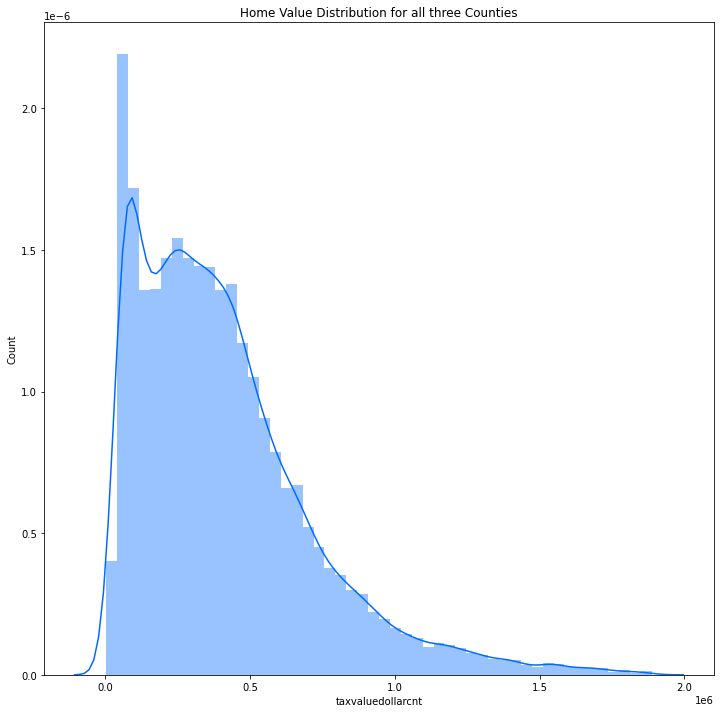

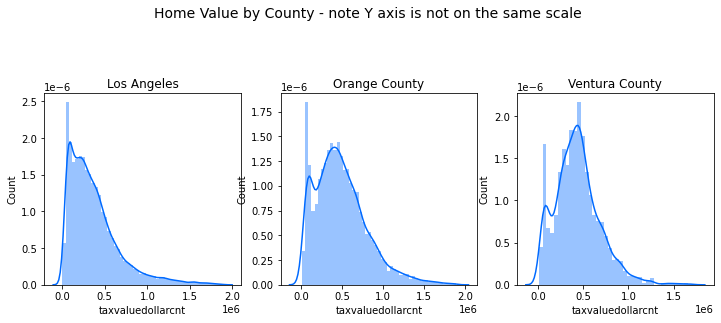

In [7]:
#function to bring in visuals for Home Value distribution
explore.homevalue_distro_visualization(train)

In [8]:
#function to bring in Home Value distro summary
explore.home_value_summary(train)

,Mean Home Value,Median Home Value,Max Home Value,Min Home Value,STD of Home Values
County,,,,,
Los Angeles,371353,299857,1887454,3254,300333
Orange,489776,445810,1884489,13524,315591
Ventura,438641,422288,1703000,9242,248118


Takeaways:
- Orange County has higher priced homes in every category
- Veentura County has the smallest gap between the mean and Median which is why their home values is more normally distributed on the chart above
- LA County on average has the lowest priced homes but they also have the highest priced homes.

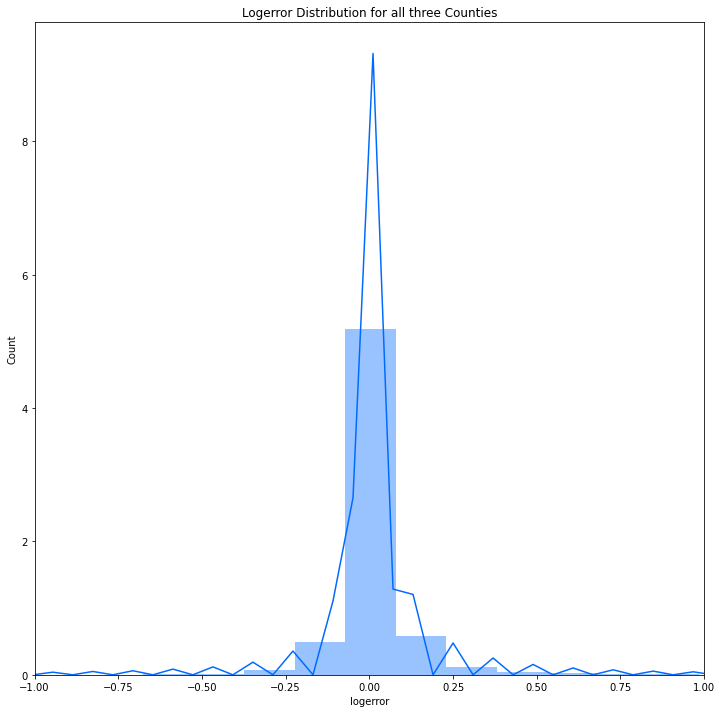

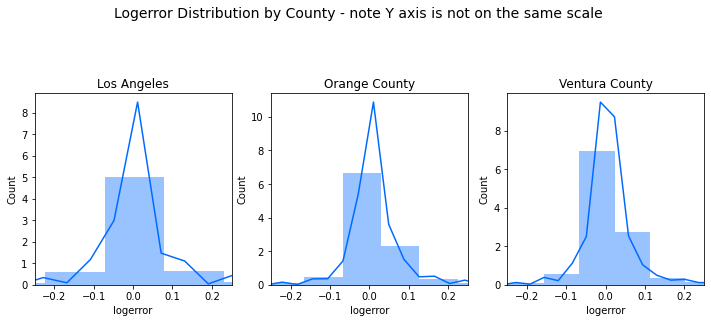

In [9]:
#function to bring in visuals for logerror distribution
explore.logerror_distro_visualization(train)

In [10]:
#function to bring in Distro summary for Logerror by County
explore.logerror_summary(train)

,Mean Logerror,Median Logerror,Max Logerror,Min Logerror,STD of Logerror
County,,,,,
Los Angeles,0.015265,0.005309,3.100913,-4.453964,0.158107
Orange,0.023485,0.007790,2.465684,-2.406257,0.177864
Ventura,0.013696,0.004695,2.177363,-2.311473,0.137137


Takeaways:
- Los Angles has the highest Logerror - which makes sense since most of our properties are in this county

- We feel that we can get a more evenly distributed logerror so we will try clustering by location after we cluster by our Target variable

## Cluster the Target Variable

- Perform clustering with logerror as the only feature used in the clustering algorithm. 
- Decide on a number of clusters to use, and store the cluster predictions back onto your data frame as cluster_target.
- Look at the centroids that were produced in this process.
    - What do they tell you?

     k         sse
0    2  523.337846
1    3  368.117392
2    4  259.384579
3    5  194.103070
4    6  139.795666
5    7  105.043431
6    8   81.411284
7    9   64.258999
8   10   52.327364
9   11   43.745888
10  12   37.194365
11  13   32.316154
12  14   27.672867
13  15   24.235599
14  16   21.062833
15  17   18.714166
16  18   16.729859
17  19   15.126473


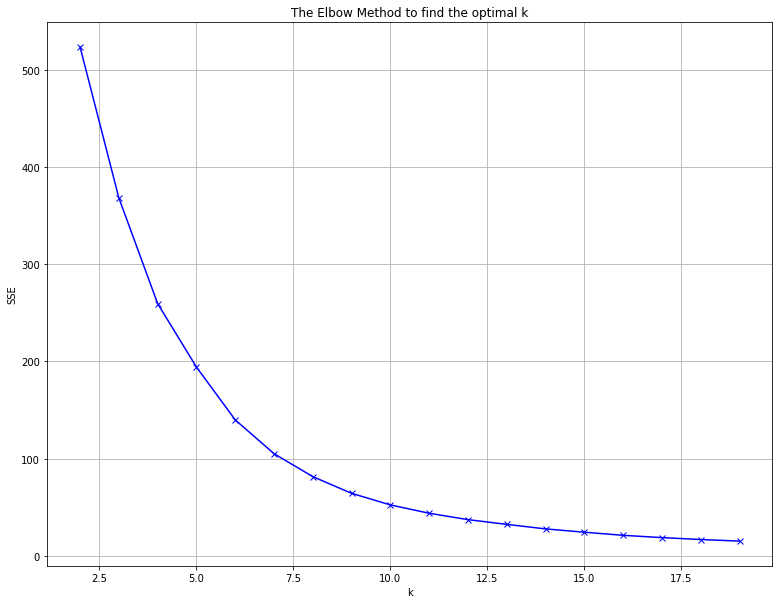

In [11]:
cluster_target = train[["logerror"]]

#Run function to find the optimal k value
explore.find_optimal_k(cluster_target)

- **We are going to go with a k of 6 since it's roughly the center of the elbow**

In [12]:
#cluster and add to train and test
train, test, kmeans = explore.cluster_target_variable(train, test)

In [13]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=cluster_target.columns)
centroids

,logerror
0,-0.169187
1,0.664752
2,0.004321
3,2.140978
4,0.180102
5,-1.252734


**Takeaways**
- The centroids are all relatively well spaced out

Now let's look at a few variables with the logerror cluster we just created

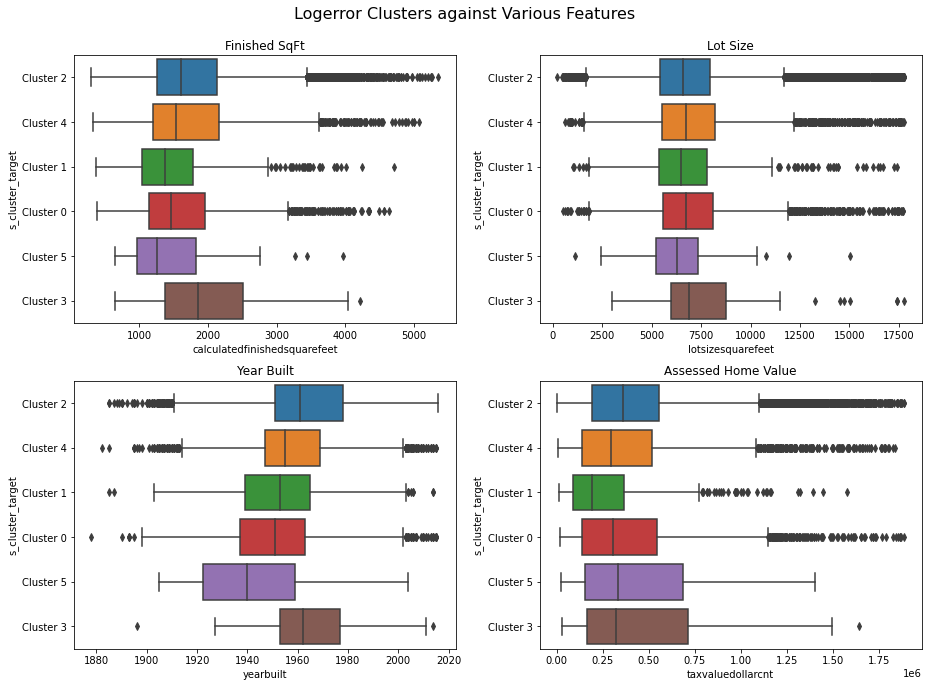

In [14]:
#function to bring in boxplots
explore.boxplots_for_logerror_clusters(train)

## Explore Correlations

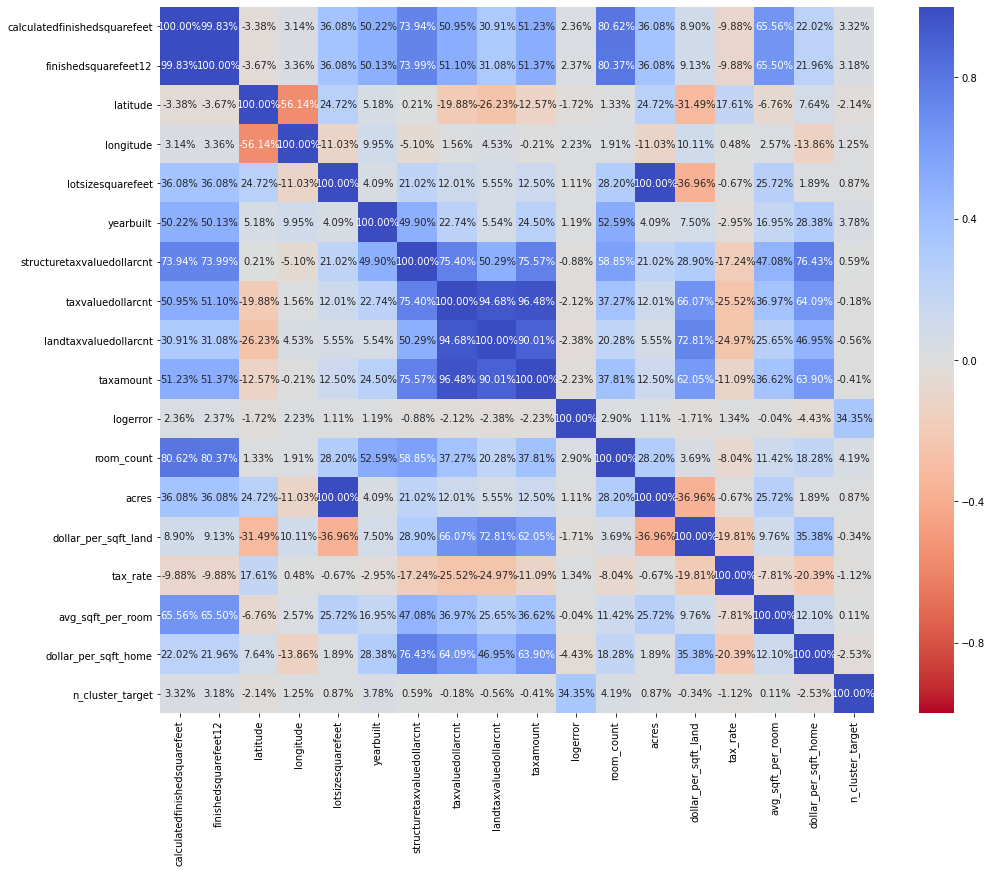

In [15]:
plt.figure(figsize=(16,13))
sns.heatmap(train.corr(), annot=True, cmap="coolwarm_r", fmt=".2%", vmin=-1, vmax=1)

- Since the a above heatmap is a bit overwhelming we'll create a smaller dataframe to explore

In [16]:
df = train[["calculatedfinishedsquarefeet", "lotsizesquarefeet", "yearbuilt", 
            "taxvaluedollarcnt", "logerror", "extras", "County", "room_count",
            "acres", "dollar_per_sqft_land", "avg_sqft_per_room", "dollar_per_sqft_home"]]

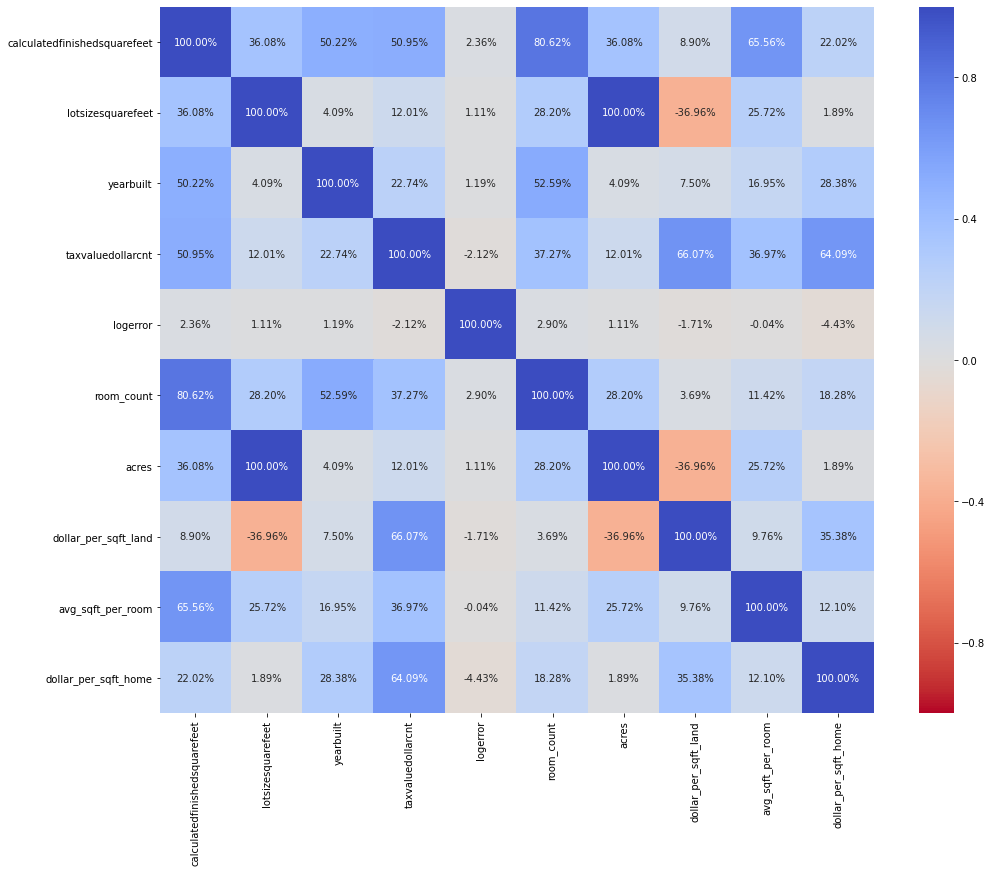

In [17]:
plt.figure(figsize=(16,13))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm_r", fmt=".2%", vmin=-1, vmax=1)

Takeaways:
- Nothing seems to be strongly correlated to logerror.

Next Steps:   
- cluster variables: calculatedsquarefeet, yearbuilt, roomcount, latitude, longitude

## Cluster Independent Variables

### Location cluster

By clustering latitude and logituste we are hoping to have a more granular area instead of using the County's

     k          sse
0    2  1093.001172
1    3   780.449062
2    4   531.368122
3    5   396.691413
4    6   296.884216
5    7   229.019272
6    8   187.162445
7    9   166.371006
8   10   149.798130
9   11   131.289111
10  12   115.230910
11  13   101.827288
12  14    93.273951
13  15    86.046892
14  16    80.804261
15  17    75.762929
16  18    72.029101
17  19    68.364860


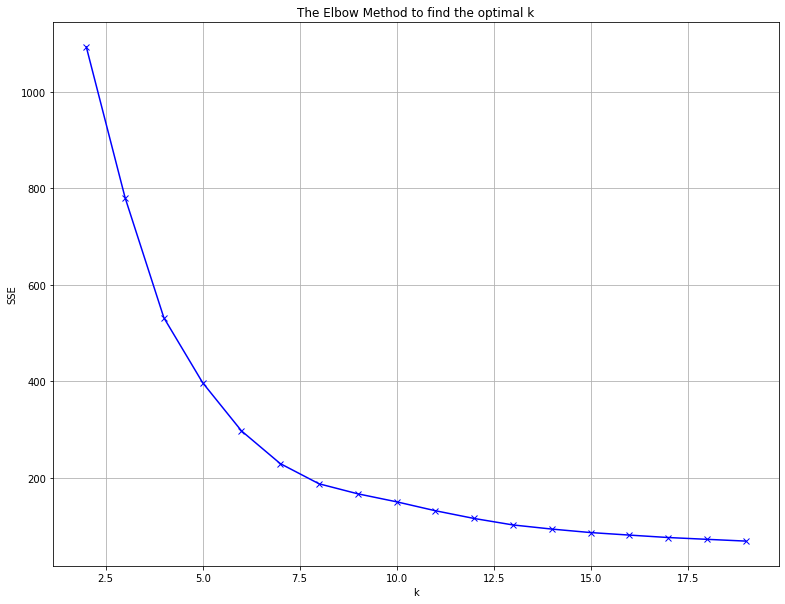

In [18]:
location_cluster = train_scaled[["latitude", "longitude"]]

#find optimal K
explore.find_optimal_k(location_cluster)

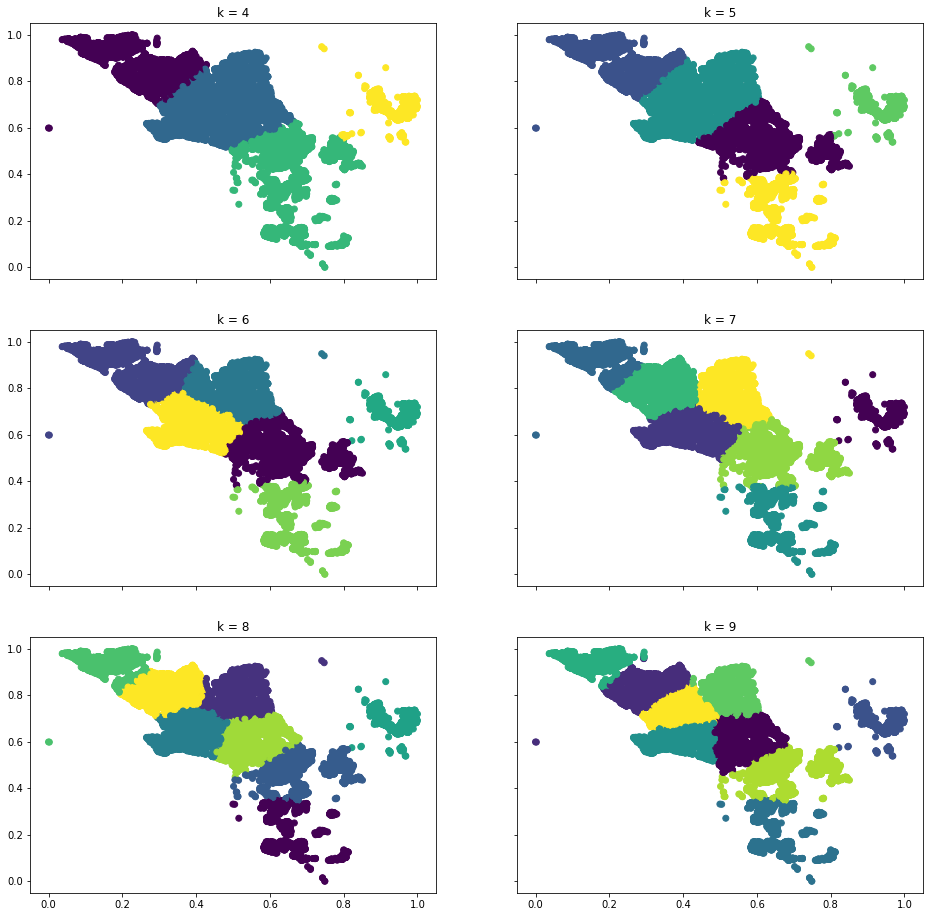

In [37]:
#Take a closer look at k values 5-9
explore.elbow_k_means_plots_2_vars(4, 10, location_cluster)

**Takeaways:**
- 5 and 6 are looking like our best value for K

- for lat and long (our location cluster) we are going to run stats tests on k of 5 and 6 to see which one is more significant

#### Implementation

- We are going to create 2 location clusters with with k of 5 and 6 and add both onto our dataframes(train, test)
- Run T-tests for logerror
- Evaluate each k clustering performance and drop the one that does not perform as well from out dataframes(train, test)

In [20]:
#function to predict and fit onto test and train
train, test, kmeans5, kmeans6 = explore.get_location_clusters(train, test)

**T-Test for K of 5**

- $H_0$ = There is no difference between the mean logerror scores for cluster 0 and the overall mean logerror
- $H_0$ = There is no difference between the mean logerror scores for cluster 1 and the overall mean logerror
- $H_0$ = There is no difference between the mean logerror scores for cluster 2 and the overall mean logerror
- $H_0$ = There is no difference between the mean logerror scores for cluster 3 and the overall mean logerror
- $H_0$ = There is no difference between the mean logerror scores for cluster 4 and the overall mean logerror

In [21]:
#function to run the T-Test on KMeans with 5
p0, p1, p2, p3, p4 = explore.t_test_location_cluster_k5(train)

We fail to reject the null hypothesis for for Cluster 0
We reject the null hypothesis for Cluster 1
We reject the null hypothesis for Cluster 2
We fail to reject the null hypothesis for Cluster 3
We fail to reject the null hypothesis for Cluster 4
Our p value for Cluster 0 is 0.48
Our p value for Cluster 1 is 0.00057
Our p value for Cluster 2 is 0.0038
Our p value for Cluster 3 is 0.38
Our p value for Cluster 4 is 0.31


In [22]:
(train.n_location_cluster_k5.value_counts() / len(train)) *100

0    38.142726
2    25.611467
1    22.525160
4     7.474840
3     6.245807
Name: n_location_cluster_k5, dtype: float64

**Takeaways**
- There is significance in 2 of the clusters when compared to logerror
    - The 3 new zones that have the some significance are also the largest sections

**T-Test for K of 6**

- $H_0$ = There is no difference between the mean logerror scores for cluster 0 and the overall mean logerror
- $H_0$ = There is no difference between the mean logerror scores for cluster 1 and the overall mean logerror
- $H_0$ = There is no difference between the mean logerror scores for cluster 2 and the overall mean logerror
- $H_0$  = There is no difference between the mean logerror scores for cluster 3 and the overall mean logerror
- $H_0$  = There is no difference between the mean logerror scores for cluster 4 and the overall mean logerror
- $H_0$  = There is no difference between the mean logerror scores for cluster 6 and the overall mean logerror

In [23]:
k6p0, k6p1, k6p2, k6p3, k6p4, k6p5 = explore.t_test_location_cluster_k6(train)

We fail to reject the null hypothesis for Cluster 0
We reject the null hypothesis for Cluster 1
We reject the null hypothesis for Cluster 2
We fail to reject the null hypothesis for Cluster 3
We reject the null hypothesis for Cluster 4
We reject the null hypothesis for Cluster 5
Our p value for Cluster 0 is 0.38
Our p value for Cluster 1 is 0.017
Our p value for Cluster 2 is 1.2e-05
Our p value for Cluster 3 is 0.99
Our p value for Cluster 4 is 0.00014
Our p value for Cluster 5 is 0.00014


In [24]:
(train.n_location_cluster_k6.value_counts() / len(train)) *100

4    27.923147
2    25.571821
3    17.407746
1    16.355596
5     6.505032
0     6.236658
Name: n_location_cluster_k6, dtype: float64

**Takeaways**
- There is significance in 4 of the clusters when compared to logerror
- These zones are a bit more evenly distributed
- After looking at both of these clusters we have decided to keep both and see if one outperforms in the modeling stage

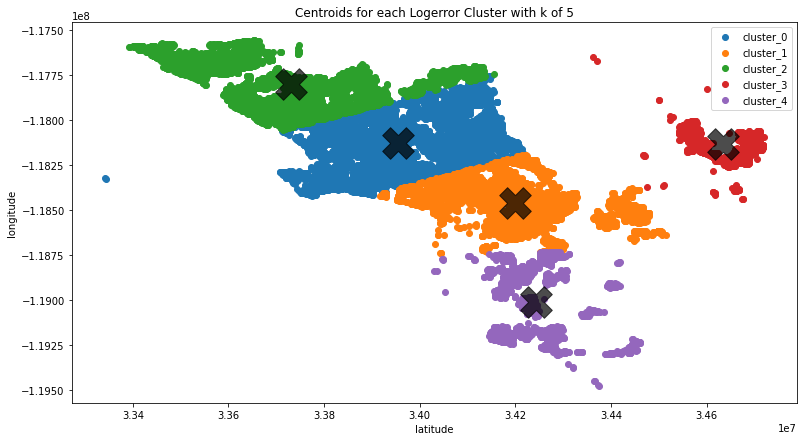

In [25]:
X_train = train[["latitude", "longitude"]]
plt.figure(figsize=(13, 7))
for cluster, subset in train.groupby('s_location_cluster_k5'):
    plt.scatter(subset.latitude, subset.longitude, label=cluster)

centroids_k5 = pd.DataFrame(kmeans5.cluster_centers_, columns=X_train.columns)    

centroids_k5.plot.scatter(x='latitude', y='longitude', ax=plt.gca(), alpha=.7, s=1000, c='black', marker="X")
plt.title("Centroids for each Logerror Cluster with k of 5")
plt.legend()

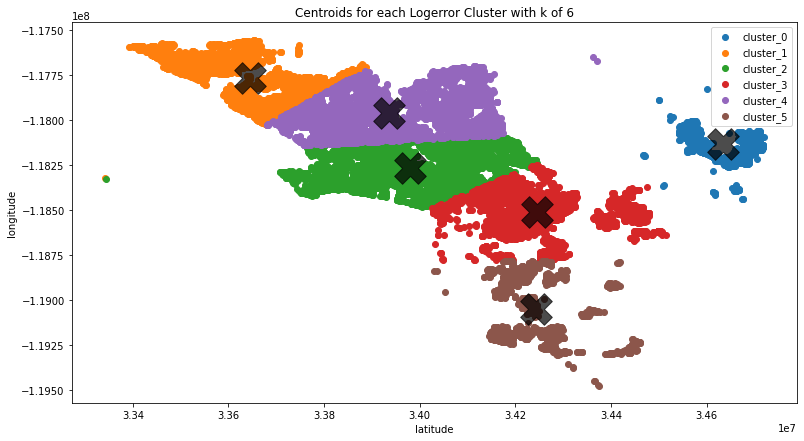

In [26]:
X_train = train[["latitude", "longitude"]]
plt.figure(figsize=(13, 7))
for cluster, subset in train.groupby('s_location_cluster_k6'):
    plt.scatter(subset.latitude, subset.longitude, label=cluster)

centroids_k6 = pd.DataFrame(kmeans6.cluster_centers_, columns=X_train.columns)    

centroids_k6.plot.scatter(x='latitude', y='longitude', ax=plt.gca(), alpha=.7, s=1000, c='black', marker="X")
plt.title("Centroids for each Logerror Cluster with k of 6")
plt.legend()

In [27]:
centroids_k5

,latitude,longitude
0,3.395528e+07,-1.181273e+08
1,3.419933e+07,-1.184611e+08
2,3.373126e+07,-1.178033e+08
3,3.463423e+07,-1.181363e+08
4,3.424296e+07,-1.190105e+08


In [28]:
centroids_k6

,latitude,longitude
0,3.463457e+07,-1.181366e+08
1,3.364495e+07,-1.177652e+08
2,3.397890e+07,-1.182704e+08
3,3.424512e+07,-1.185145e+08
4,3.393630e+07,-1.179608e+08
5,3.424303e+07,-1.190482e+08


### Year built, room count, and sqft cluster

     k          sse
0    2  1133.991127
1    3   843.880938
2    4   696.296304
3    5   575.399575
4    6   497.785780
5    7   440.718157
6    8   395.893563
7    9   361.801994
8   10   336.689570
9   11   314.330117
10  12   298.989610
11  13   285.595842
12  14   270.726711
13  15   257.885006
14  16   246.085571
15  17   235.554378
16  18   227.246597
17  19   220.780953


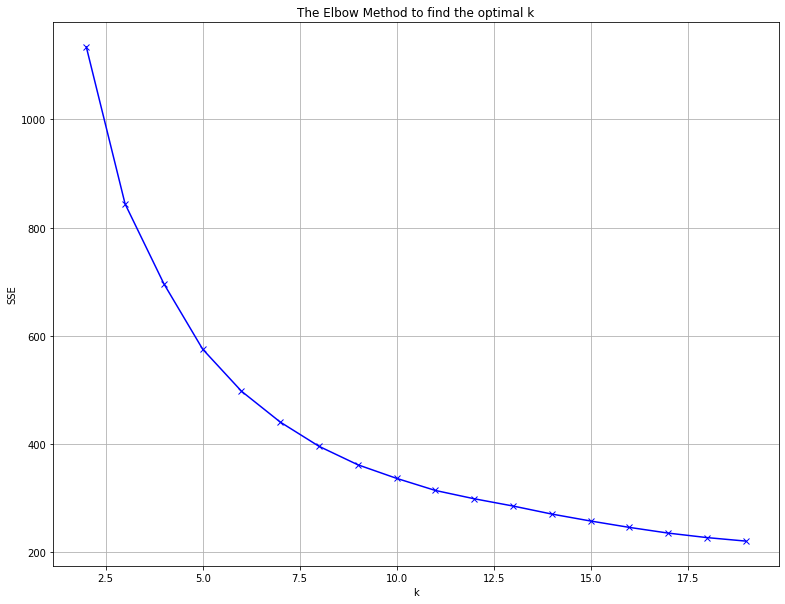

In [29]:
clusters = train_scaled[["calculatedfinishedsquarefeet", "room_count", "yearbuilt"]]

#find optimal k
explore.find_optimal_k(clusters)

- Going to go with a cluster of 6 because it's roughly in the middle of the elbow bend

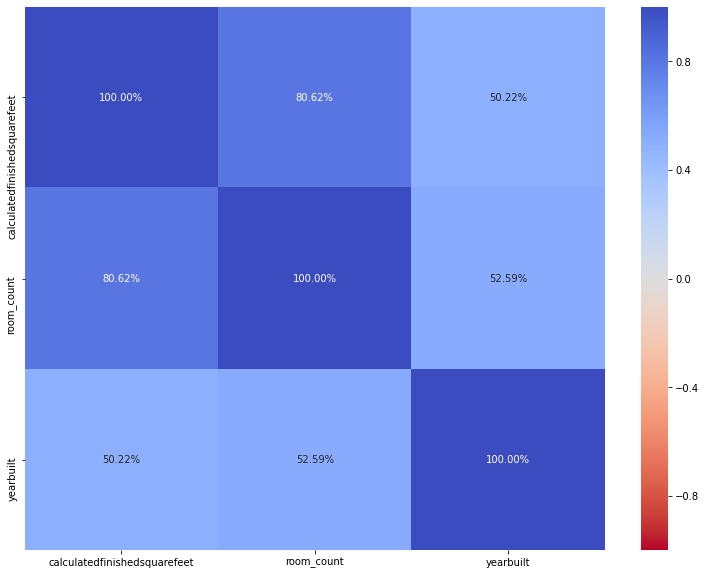

In [30]:
plt.figure(figsize=(13,10))
sns.heatmap(clusters.corr(),annot=True, cmap="coolwarm_r", fmt=".2%", vmin=-1, vmax=1)

- Since these features seemed to be strongly correlated to one another we decided to cluster them

In [31]:
kmeans, train, test = explore.cluster_year_sqft_roomcount(train_scaled, test_scaled, train, test)

<Figure size 936x720 with 0 Axes>

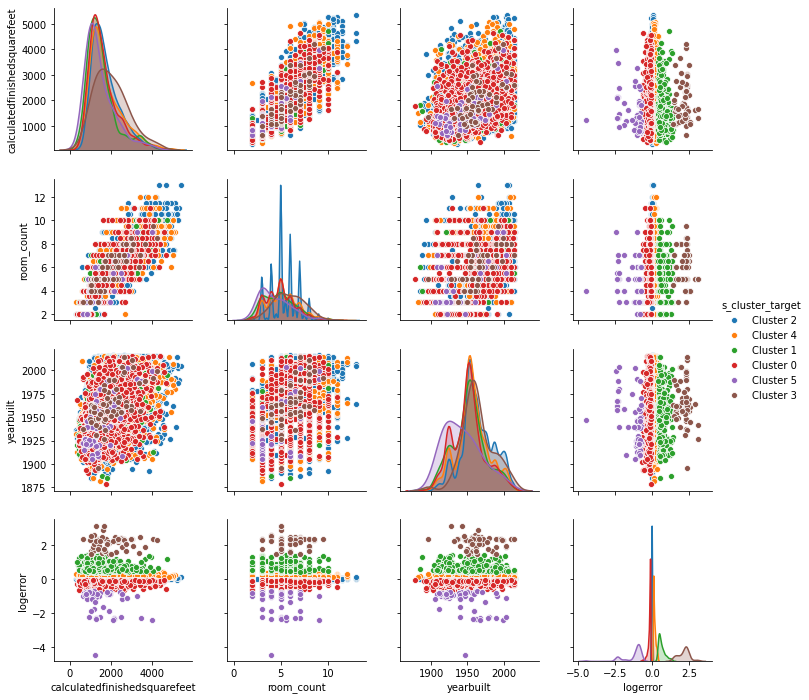

In [32]:
X_train = train[["calculatedfinishedsquarefeet", "room_count", "yearbuilt", "logerror", "County", "s_cluster_target"]]
plt.figure(figsize=(13,10))
sns.pairplot(X_train, hue="s_cluster_target")

### T Test for size clustering
- $H_0$ = There is no difference between the mean logerror scores for cluster 0 and the overall mean logerror
- $H_0$ = There is no difference between the mean logerror scores for cluster 1 and the overall mean logerror
- $H_0$ = There is no difference between the mean logerror scores for cluster 2 and the overall mean logerror
- $H_0$  = There is no difference between the mean logerror scores for cluster 3 and the overall mean logerror
- $H_0$  = There is no difference between the mean logerror scores for cluster 4 and the overall mean logerror
- $H_0$  = There is no difference between the mean logerror scores for cluster 6 and the overall mean logerror

In [33]:
explore.t_test_year_sqft_roomcount(train)

We reject the null hypothesis for Cluster 0
We reject the null hypothesis for Cluster 1
We reject the null hypothesis for Cluster 2
We fail to reject the null hypothesis for Cluster 3
We fail to reject the null hypothesis for Cluster 4
We reject the null hypothesis for Cluster 5
Our p value for Cluster 0 is 0.0021
Our p value for Cluster 1 is 0.0027
Our p value for Cluster 2 is 0.0031
Our p value for Cluster 3 is 0.75
Our p value for Cluster 4 is 0.9
Our p value for Cluster 5 is 0.0013


(0.002137334623512548,
 0.002721794154351693,
 0.003065001403584965,
 0.7485724553280505,
 0.903415606890645,
 0.0013392063783761294)

Takeaways:
- Based on the above this cluster should be worth exploring in the models

# Modeling

## First let's bring in the data fresh again

In [34]:
# Bring in the prepared data and add the new features
zillow = preprocessing.new_features(prepare.wrangle_data())
# Split the data into train and test
train, test = preprocessing.split_data(zillow)
# Add on the logerror clusters
train, test, log_cluster = explore.cluster_target_variable(train, test)
# Add on the location clusters
train, test, loc_clusters_5, loc_clusters_6 = explore.get_location_clusters(train, test)
# Create scaled copies for year_size clusters
scaler, train_scaled, test_scaled = preprocessing.scale_columns(train, test)
# Add year_size clusters
size_year_cluster, train, test = explore.cluster_year_sqft_roomcount(train_scaled, test_scaled, train, test)
# Add validation split
train, val = preprocessing.split_data(train)
train

,calculatedfinishedsquarefeet,finishedsquarefeet12,latitude,longitude,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,transactiondate,extras,County,room_count,acres,dollar_per_sqft_land,tax_rate,avg_sqft_per_room,dollar_per_sqft_home,trans_month,trans_day,n_cluster_target,s_cluster_target,n_location_cluster_k5,s_location_cluster_k5,n_location_cluster_k6,s_location_cluster_k6,n_size_and_year_cluster,s_size_and_year_cluster
49806,1463.0,1463.0,33703280.0,-117947569.0,6851.0,1969.0,116838.0,371770.0,254932.0,4212.60,-0.022769,2017-09-06,Garage and Pool,Orange,5.0,0.157277,37.210918,0.011331,292.600000,79.861928,09,06,2,Cluster 2,2,cluster_2,1,cluster_1,4,cluster_4
26320,2210.0,2210.0,33719277.0,-117923071.0,7202.0,1973.0,85321.0,125880.0,40559.0,1629.06,0.355603,2017-05-24,Garage and Pool,Orange,7.0,0.165335,5.631630,0.012941,315.714286,38.606787,05,24,4,Cluster 4,2,cluster_2,1,cluster_1,2,cluster_2
42136,1413.0,1413.0,34087737.0,-118106398.0,6202.0,1925.0,15301.0,45511.0,30210.0,899.59,0.042700,2017-07-31,No Pool or Garage,Los Angeles,4.0,0.142378,4.871009,0.019766,353.250000,10.828733,07,31,2,Cluster 2,0,cluster_0,2,cluster_2,1,cluster_1
4152,1333.0,1333.0,33926736.0,-117994245.0,6936.0,1961.0,49477.0,81757.0,32280.0,1271.77,-0.009289,2017-01-29,Pool Only,Los Angeles,5.0,0.159229,4.653979,0.015555,266.600000,37.117029,01,29,2,Cluster 2,0,cluster_0,4,cluster_4,4,cluster_4
40805,1003.0,1003.0,33801373.0,-118259988.0,4998.0,1944.0,67341.0,90267.0,22926.0,1452.94,-0.033745,2017-07-25,No Pool or Garage,Los Angeles,4.0,0.114738,4.587035,0.016096,250.750000,67.139581,07,25,2,Cluster 2,0,cluster_0,2,cluster_2,3,cluster_3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31313,761.0,761.0,34050086.0,-118101577.0,6781.0,1947.0,91012.0,245836.0,154824.0,3097.67,0.166579,2017-06-14,No Pool or Garage,Los Angeles,3.0,0.155670,22.832031,0.012601,253.666667,119.595269,06,14,4,Cluster 4,0,cluster_0,4,cluster_4,3,cluster_3
35517,2187.0,2187.0,34137140.0,-118429678.0,10264.0,1959.0,106202.0,531037.0,424835.0,6699.63,-0.001125,2017-06-30,Pool Only,Los Angeles,7.0,0.235629,41.390783,0.012616,312.428571,48.560585,06,30,2,Cluster 2,1,cluster_1,3,cluster_3,2,cluster_2
836,1365.0,1365.0,33951353.0,-118265225.0,5323.0,1928.0,72486.0,238170.0,165684.0,3183.67,-0.017090,2017-01-06,No Pool or Garage,Los Angeles,5.0,0.122199,31.126057,0.013367,273.000000,53.103297,01,06,2,Cluster 2,0,cluster_0,2,cluster_2,1,cluster_1
42335,1300.0,1300.0,33703515.0,-118018857.0,6000.0,1966.0,69098.0,685293.0,616195.0,7637.98,0.004104,2017-07-31,Garage Only,Orange,6.0,0.137741,102.699167,0.011146,216.666667,53.152308,07,31,2,Cluster 2,2,cluster_2,4,cluster_4,4,cluster_4


## We found that `room_count`, `yearbuilt`, `tax_rate`, `dollar_per_sqft_home`, `dollar_per_sqft_land`, and `lotsizesquarefeet` were the best features to predict `logerror`. So we will use this to build a model without clusters so we can see how it does against the clusters.

In [35]:
model.create_model_without_clusters(train, val)

RMSE:
lr_best_model_no_clusters    0.159838
baseline_mean                0.159978
dtype: float64


The model beat the baseline by 0.00014


### Great, our model does better than the baseline by 0.00014, so it has some value. 

## Let's see if we can do better with the clusters.
## First we will start with our logerror clusters.

In [36]:
model.create_model_with_logerror_clusters(train, val)

Logerror Cluster 0 RMSE:
cluster_0_baseline_mean     0.109932
cluster_0_lr_predictions    0.110541
dtype: float64
The baseline beat the model by 0.00061


Logerror Cluster 1 RMSE:
cluster_1_baseline_mean     0.214261
cluster_1_lr_predictions    0.218914
dtype: float64
The baseline beat the model by 0.00465


Logerror Cluster 2 RMSE:
cluster_2_lr_predictions    0.035908
cluster_2_baseline_mean     0.035994
dtype: float64
The model beat the baseline by 0.00009


Logerror Cluster 3 RMSE:
cluster_3_baseline_mean     0.344023
cluster_3_lr_predictions    0.466367
dtype: float64
The baseline beat the model by 0.12234


Logerror Cluster 4 RMSE:
cluster_4_lr_predictions    0.083848
cluster_4_baseline_mean     0.084026
dtype: float64
The model beat the baseline by 0.00018


Logerror Cluster 5 RMSE:
cluster_5_baseline_mean     0.879105
cluster_5_lr_predictions    0.880608
dtype: float64
The baseline beat the model by 0.00150


The models, on average, were beat by the baseline by 0.02147


### So modeling by the logerror clusters did not go well as it was beaten by the baseline more often than not.

## Next let's try to model based on the location clusters

In [37]:
model.create_model_with_location_clusters(train, val)

Location Cluster 0 RMSE:
cluster_0_lr_predictions    0.163982
cluster_0_baseline_mean     0.164558
dtype: float64
The model beat the baseline by 0.00058


Location Cluster 1 RMSE:
cluster_1_baseline_mean     0.181429
cluster_1_lr_predictions    0.182004
dtype: float64
The baseline beat the model by 0.00057


Location Cluster 2 RMSE:
cluster_2_lr_predictions    0.180219
cluster_2_baseline_mean     0.180220
dtype: float64
The model beat the baseline by 0.00000


Location Cluster 3 RMSE:
cluster_3_lr_predictions    0.134456
cluster_3_baseline_mean     0.134679
dtype: float64
The model beat the baseline by 0.00022


Location Cluster 4 RMSE:
cluster_4_lr_predictions    0.140721
cluster_4_baseline_mean     0.141052
dtype: float64
The model beat the baseline by 0.00033


Location Cluster 5 RMSE:
cluster_5_lr_predictions    0.143317
cluster_5_baseline_mean     0.143718
dtype: float64
The model beat the baseline by 0.00040


The models, on average, beat the baseline by 0.00016


### This is better than our original model that beat the baseline by 0.00014 so we can see that the location clusters hold some value.

## Now let's try out the size and year clusters

In [38]:
model.create_model_with_size_and_year_clusters(train, val)

Size and Year Cluster 0 RMSE:
cluster_0_baseline_mean     0.142389
cluster_0_lr_predictions    0.142791
dtype: float64
The baseline beat the model by 0.00040


Size and Year Cluster 1 RMSE:
cluster_1_lr_predictions    0.185655
cluster_1_baseline_mean     0.186810
dtype: float64
The model beat the baseline by 0.00116


Size and Year Cluster 2 RMSE:
cluster_2_baseline_mean     0.191150
cluster_2_lr_predictions    0.191885
dtype: float64
The baseline beat the model by 0.00074


Size and Year Cluster 3 RMSE:
cluster_3_baseline_mean     0.204436
cluster_3_lr_predictions    0.204574
dtype: float64
The baseline beat the model by 0.00014


Size and Year Cluster 4 RMSE:
cluster_4_lr_predictions    0.139771
cluster_4_baseline_mean     0.140007
dtype: float64
The model beat the baseline by 0.00024


Size and Year Cluster 5 RMSE:
cluster_5_baseline_mean     0.106235
cluster_5_lr_predictions    0.106394
dtype: float64
The baseline beat the model by 0.00016


The models, on average, were beat by the

### So these models also lost to the baseline more often than they beat it.

## So our best model has been using the location clusters with a Linear Regression model. Let's see how it preforms on the test data

In [39]:
model.create_test_model_with_location_cluster(train, test)

Location Cluster 0 RMSE:
cluster_0_baseline_mean     0.102769
cluster_0_lr_predictions    0.103199
dtype: float64
The baseline beat the model by 0.00043


Location Cluster 1 RMSE:
cluster_1_baseline_mean     0.212857
cluster_1_lr_predictions    0.213475
dtype: float64
The baseline beat the model by 0.00062


Location Cluster 2 RMSE:
cluster_2_baseline_mean     0.199033
cluster_2_lr_predictions    0.199131
dtype: float64
The baseline beat the model by 0.00010


Location Cluster 3 RMSE:
cluster_3_lr_predictions    0.148523
cluster_3_baseline_mean     0.148611
dtype: float64
The model beat the baseline by 0.00009


Location Cluster 4 RMSE:
cluster_4_baseline_mean     0.146042
cluster_4_lr_predictions    0.146077
dtype: float64
The baseline beat the model by 0.00004


Location Cluster 5 RMSE:
cluster_5_baseline_mean     0.189014
cluster_5_lr_predictions    0.189223
dtype: float64
The baseline beat the model by 0.00021


The models, on average, beat the baseline by -0.00022


## So our model doesn't do as well on the test data.

# Modeling Takeaways

* The location performed the best on the validation data but only slightly better than a model with no clusters
* The size and year cluster and the logerror clusters did not perform well.
* While the location cluster performed well on the validation data, it did poorly against the test data

# Next Steps
* Find best features for each cluster and use them in the model for each cluster.
* Find new clusters by combining cost of homes.
* Create new features based on the clusters unique properties and use in modeling.